### Fake News Classifier using Political Affiliation

- Name: Anushri Srinath Aithal
- Student ID: 012506897
- Team: Codebusters
- Feature: Political Affiliation
- GitHub: https://github.com/shriaithal/AlternusVera

#### Business Problem

The widespread propagation of false information online is not a recent phenomenon but its perceived impact in the 2016 U.S. presidential election has thrust the issue into the spotlight. Technology companies are already exploring machine learning-based approaches for solving the problem. In this project, we are using NLP based text classification to identify the different news categories.

#### Data

- Politifact Liar Liar Data - https://drive.google.com/open?id=1IVl4Qt92LZwvMlnJGRcEZVKF-dpawhdz

**Description of the Data:**
- Column 1: the ID of the statement.
- Column 2: the label.
- Column 3: the statement.
- Column 4: the subject(s).
- Column 5: the speaker.
- Column 6: the speaker's job title.
- Column 7: the state info.
- Column 8: the party affiliation.
- Column 9-13: the total credit history count, including the current statement.
- Column 14: the context (venue / location of the speech or statement).

#### Features for Fake News Classification from Fake News Article

1. Social acceptance = # of likes, # of comments (short term utility)
2. Bias Score
3. Spam Score
4. Website credibility/ Domain Ranking
5. Author credibility
6. Political Affliation
7. Occurance Location (Probability of announcing on Radio or Press release being fake is low)
8. Sensationalism/Psychology Utility - agreeing with reader's prior beliefs
9. Frequency Heuristic - Constant repetition makes them believe (Sensationlism)
10. Echo Chamber - Forming groups and spreading opinions
11. Visual - Images, Links, Videos

#### Political Affiliation

Political bias/affliation towards certain political parties, political leaders can influence fake news origin. An unbiased view on media reports requires an understanding of the political bias of media content. According to the paper "Automating Political Bias Prediction" by "Felix Biessmann", political power appears to be strongly correlated with positive sentiment of a text. 

#### What did not work?

As a part of Sprint 1 of Alternus Vera, I started out trying to analyze the attitude towards a political dictionary. The political dictionary from the Stanford Political Library (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VHXN5F) provides a set of words with a polarity indicating the attitude with which people percieve those words. I applied various NLP methodologies in this approach namely - COunt Vector, TF-IDF, Word2Vec and Doc2Vec approach using the dictionary of words and its polarity for vectorization. These approaches however did not provide satisfactory accuracy for classification of Fake News. I was able to achieve only **19%** accuracy. This approach clearly did not work for me and all the steps followed in this approach is part of another notebook namely **political_affiliation_implA.ipynb**

#### What worked?

As mentioned above, using political affiliation alone as a feature did not yield a great result. Also, the word overlap between the Standford dictionary and Liar Liar dataset was poor. In this notebook a novel approach of distillation is used to improve the classification accuracy. Without distillation, an accuracy of **37%** was achieved. Post distillation accuracy is **54%**. The entire process performed is laid out in the next section and the steps are explained briefly in this notebook.

#### Feature Engineering: Political Affiliation Vector Approach 5 Steps

1. Data Preprocessing
2. Data Visualization: Word Length Distributions, Fake News Label Distribution, Word Cloud Visualization, t-SNE visualization, Political Affiliation Label Visualization
2. Custom dictionary based on word frequency
3. TF-IDF and Classification on Political Affiliaition Labels
4. Doc2Vec and Classification on Political Affiliation Labels
5. Distillation by performing Sentiment Analysis
6. Distillation by performing LDA. Visualization of topic distribution.
6. Distillation by performing Ranking based on Speaker importance. Visualization of top 10 Speakers distribution.
7. Classification of Fake News based on the Political Affiliation vector.

#### Data Preprocessing

1. Encode the labels to 0 and 1 where 1 represents data that are original, true, mostly-true and 0 represents fake and falsified news
2. Convert all textual data from upper case to lower case.
3. Remove stop words
4. Perform spell check
5. Wordnet Lemmatization for verbs
6. Stemming using snowball filter
7. Remove punctuation from all textual fields.
8. Remove short words, words containing less than 3 letters.

In [74]:
# load required libraries and read data
import os
import pandas as pd
import numpy as np
import seaborn as sns
import gensim
import string
import operator
import re
import nltk
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gensim.models import word2vec
from nltk import word_tokenize
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from scipy import spatial
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## ignore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [75]:
#method to load data
colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']
def load_train_data():
    #load data
    train_filename = 'input_data/train.tsv'
    train_news = pd.read_csv(train_filename, sep='\t', names = colnames,error_bad_lines=False)
    return train_news

def load_test_data():
    test_filename = 'input_data/test.tsv'
    test_news = pd.read_csv(test_filename, sep='\t', names = colnames,error_bad_lines=False)
    return test_news

**Label Encoding:** Encode the labels to 0 and 1 where 1 represents data that are original, true, mostly-true and 0 represents fake and falsified news

In [76]:
#label encoding
true_labels = ['original','true','mostly-true','half-true']
false_labels = ['barely-true','false','pants-fire']

def encode_news_type(input_label):
    if input_label in true_labels:
        return 1
    else:
        return 0

**Remove Punctuation:** Using string library's punctuation set we identify and remove from headline text

In [77]:
#method to remove punctuations from textual data
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

**Stop Words Removal:**  A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a classification model has been programmed to ignore, both when building the model as well as when testing and validating. Stop words do not add weightage to classification algorithms. Used NLTK library to **tokenize** headline text and remove stop words.

**Wordnet Lemmatization:** Lemmatisation (or lemmatization) in linguistics, is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Using NLTK Wordnet Lemmatizer to perform lemmatization of verbs. Unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning. 

**Stemming using Snowball Filter:** In linguistic morphology and information retrieval, stemming is the process for reducing inflected (or sometimes derived) words to their stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root. The work at this stage attempts to reduce as many different variations of similar words into a single term ( different branches all reduced to single word stem). Therefore if we have "running", "runs" and "run", you would really want these three distinct words to collapse into just the word "run". (However of course you lose granularity of the past, present or future tense). **Snowball** stemmer is a more progressive **Porter** stemming algorithm. Hence in my approach I am using Snowball stemmer.

In [78]:
sw = stopwords.words('english')
stemmer = SnowballStemmer("english")

#Remove stop words
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

#Lemmetize and pos tagging
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

#Stemming
def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

**Spell Checker using Word2Vec:** It is an adaptation of Peter Norvig's spell checker. It uses word2vec ordering of words to approximate word probabilities. Indeed, Google word2vec apparently orders words in decreasing order of frequency in the training corpus. The method **correction(word)** transalates to the right spelling and returns the text.

In [79]:
"""import re
from collections import Counter

#train word2vec model using Google dictionary
model = gensim.models.KeyedVectors.load_word2vec_format('input_data/GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

#Rank the model
w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

#Spell Checker methods
def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def spell_checker(text):
    all_words = re.findall(r'\w+', text) #tokenize to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)"""

'import re\nfrom collections import Counter\n\n#train word2vec model using Google dictionary\nmodel = gensim.models.KeyedVectors.load_word2vec_format(\'input_data/GoogleNews-vectors-negative300.bin.gz\', binary=True)\nwords = model.index2word\n\n#Rank the model\nw_rank = {}\nfor i,word in enumerate(words):\n    w_rank[word] = i\n\nWORDS = w_rank\n\n#Spell Checker methods\ndef words(text): return re.findall(r\'\\w+\', text.lower())\n\ndef P(word): \n    "Probability of `word`."\n    # use inverse of rank as proxy\n    # returns 0 if the word isn\'t in the dictionary\n    return - WORDS.get(word, 0)\n\ndef correction(word): \n    "Most probable spelling correction for word."\n    return max(candidates(word), key=P)\n\ndef candidates(word): \n    "Generate possible spelling corrections for word."\n    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])\n\ndef known(words): \n    "The subset of `words` that appear in the dictionary of WORDS."\n    return set(w fo

#### Data Preprocessing: Putting all the above methods together

1. Encode the labels to 0 and 1 where 1 represents data that are original, true, mostly-true and 0 represents fake and falsified news
2. Convert all textual data from upper case to lower case.
3. Remove stop words
4. Perform spell check
5. Wordnet Lemmatization for verbs
6. Stemming using snowball filter
7. Remove punctuation from all textual fields.
8. Remove short words, words containing less than 3 letters.

These preprocessing steps are done on both the train and test data set

In [80]:
def text_preprocess(df):
    #encode labels
    df['encoded_label'] = df.apply(lambda row: encode_news_type(row['label']), axis=1)
    #convert to lower case
    df['headline_text'] = df['headline_text'].str.lower()
    #remove stop words
    df['headline_text'] = df['headline_text'].apply(remove_stopwords)
    #spell check
    #df['headline_text'] = df['headline_text'].apply(spell_checker)
    #Lemmetize
    df['headline_text'] = df['headline_text'].apply(lemmatize_stemming)
    #stemming
    df['headline_text'] = df['headline_text'].apply(stemming)
    #remove punctuation
    df['headline_text'] = df['headline_text'].apply(remove_punctuation)
    #remove less than 3 letter words
    df['headline_text']  = df.headline_text.apply(lambda i: ' '.join(filter(lambda j: len(j) > 3, i.split())))
    return df[['headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo', 'partyaffiliation', 'context', 'encoded_label']]

In [81]:
#load test and train data
train_news = load_train_data()
test_news = load_test_data()

In [82]:
#pre-processing train dataset
df_train = text_preprocess(train_news)
df_train.head(5)

,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label
0,anni list polit group support thirdtrimest abo...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,0
1,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,1
2,hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,Denver,1
3,health care reform legisl like mandat free cha...,health-care,blog-posting,NaN,NaN,none,a news release,0
4,econom turnaround start term,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN,1


In [83]:
#pre-processing test dataset
df_test = text_preprocess(test_news)
df_test.head(5)

,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label
0,build wall usmexico border take liter years,immigration,rick-perry,Governor,Texas,republican,Radio interview,1
1,wisconsin pace doubl number layoff year,jobs,katrina-shankland,State representative,Wisconsin,democrat,a news conference,0
2,john mccain done noth help vets,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,comments on ABC's This Week.,0
3,suzann bonamici support plan choic medicar adv...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,a radio show,1
4,report whether center crimin scheme violat cam...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,a web video,0


#### Data Visualization
Data visualization enabled me to analyse the data distribution across various tags in Liar Liar dataset. Inferences from visualizations are below
1. Data Visualization of headline text length: Minimum text length is 50. This is of sufficient length to make meaningful inferences for feature extraction.
2. Fake News Label Distribution: The encoded label distribution is done to understand if data is uniformly distributed across both the Fake and Not Fake labels.
3. Word Cloud: Test and Train word cloud visualization helps to understand the most used words and it's importance
4. t-SNE: t-SNE, or t-distributed stochastic neighbor embedding, is a dimensionality reduction algorithm for high-dimensional data visualization.  Word2Vec visualization is done using t-SNE

In [84]:
#text length matrix
def word_length_visualisation(df):
    text_len = []

    for i in range(len(df.headline_text)):
        text_len.append(len(str(df.headline_text[i])))
    plt.figure(figsize=(10,6))
    pd.DataFrame(text_len).hist(bins = 100)

Train Data Word Length Visualization


<Figure size 720x432 with 0 Axes>

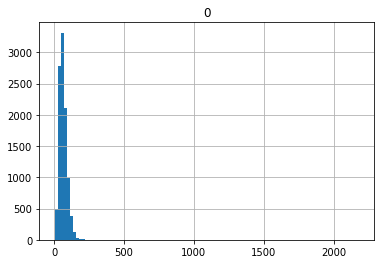

In [85]:
print('Train Data Word Length Visualization')
word_length_visualisation(df_train)

Test Data Word Length Visualization


<Figure size 720x432 with 0 Axes>

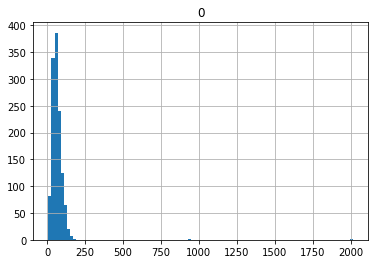

In [86]:
print('Test Data Word Length Visualization')
word_length_visualisation(df_test)

#### Analysis of Fake and Not Fake News

By grouping text based on the type and visualizing the data categories, I notice that, text is well distributed and there is not much bias in the liar liar dataset.

In [87]:
def fake_news_distribution(df):
    #Training data set with text, domain ranking and type.
    X = df[['headline_text', 'encoded_label']]

    plt.title('Category Vs Count')
    X.groupby(['encoded_label']).size().plot(kind='barh', color='blue')
    plt.xlabel('count')
    plt.show()

Train Data Fake News Encoded Label Visualization


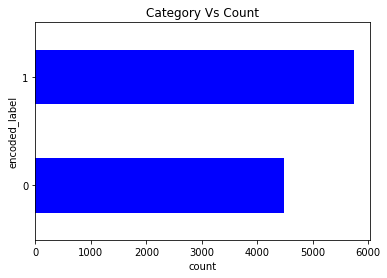

Test Data Fake News Encoded Label  Visualization


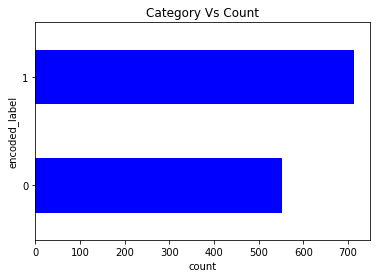

In [88]:
print('Train Data Fake News Encoded Label Visualization')
fake_news_distribution(df_train)

print('Test Data Fake News Encoded Label  Visualization')
fake_news_distribution(df_test)

**Word Cloud Inference**

From word cloud I was able to infer that the most frequently repeated words on both my train and test data are very similar. For example, words like percent, billion have been repeated the most among both data set. This information can be used for building the right models for classification using train dataset and test them using test dataset.

In [89]:
#Word Cloud to Visualize important text
# lower max_font_size, change the maximum number of word and lighten the background

def word_cloud_visualization(df):
    text = " ".join(ht for ht in df.headline_text)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Train Data Word Cloud Visualization


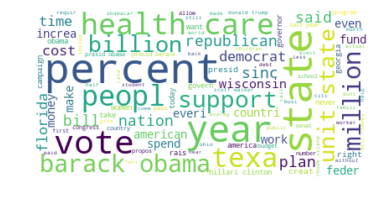

Test Data Word Cloud Visualization


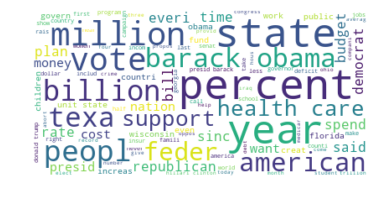

In [90]:
print('Train Data Word Cloud Visualization')
word_cloud_visualization(df_train)

print('Test Data Word Cloud Visualization')
word_cloud_visualization(df_test)

#### Word2Vec and t-SNE
TSNE is pretty useful when it comes to visualizing similarity between objects. It works by taking a group of high-dimensional (15 dimensions via Word2Vec) vocabulary word feature vectors, then compresses them down to 2-dimensional x,y coordinate pairs. The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words.

In [91]:
num_features = 15      # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

#Create Word2Vec Model. Get Vector from the model
word_tokens = []
for i in range(len(df_train)):
    words = df_train['headline_text'][i].split()
    word_tokens.append(words)
    
word2vec_model = word2vec.Word2Vec(word_tokens, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

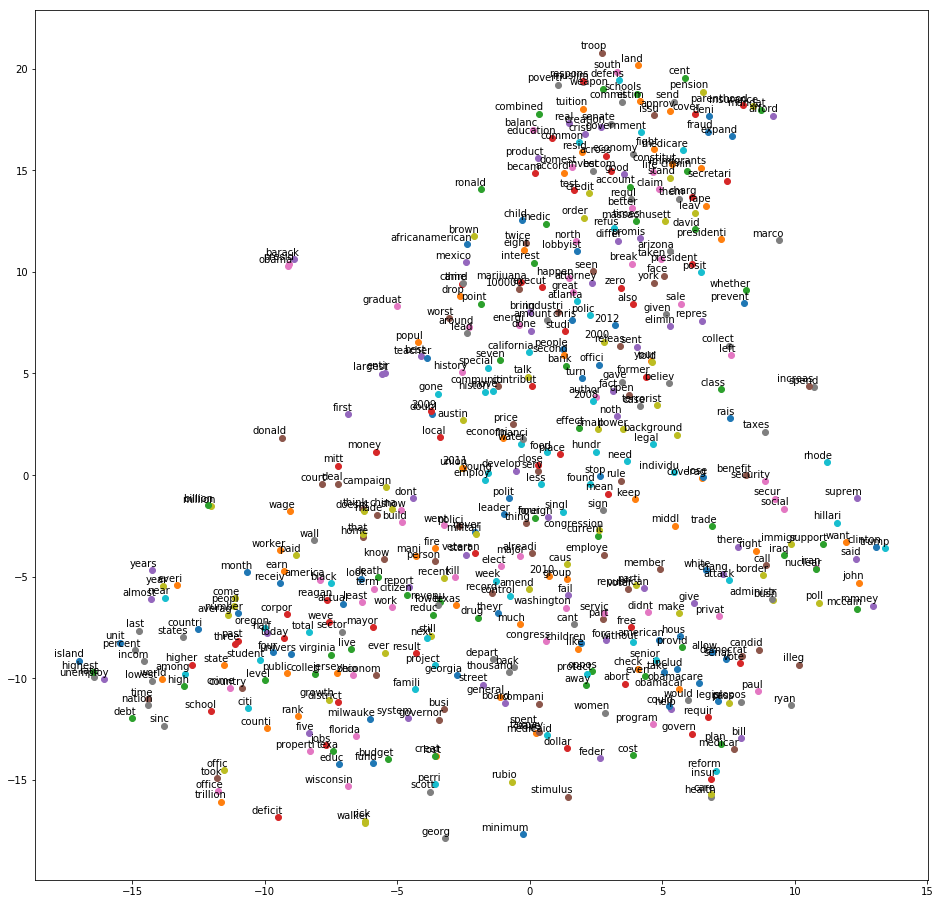

In [92]:
#"Creates and TSNE model and plots it"
from sklearn.manifold import TSNE
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(word2vec_model)

#### Feature Engineering: Political Affiliation Vector Approach 5

Approaches 1 to 5 have been described in Alternus Vera Sprint 1 notebook **political_affiliation_implA**. 

**Approach 5 using Distillation: Steps Followed**

1. Custom dictionary based on word frequency
2. TF-IDF and Classification on Political Affiliaition Labels
3. Doc2Vec and Classification on Political Affiliation Labels
4. Distillation by performing Sentiment Analysis
5. Distillation by performing LDA. Visualization of topic distribution.
6. Distillation by performing Ranking based on Speaker importance. Visualization of top 10 Speakers distribution.
7. Classification of Fake News based on the Political Affiliation vector.

**Party Affiliation Text**
From the Distribution graphs below we notice that data is distributed highly between 4 labels Democrat, Republican, Independent and None. For understanding the classification based on political affiliation, I will consider only these 4 labels. I will also encode all the other tags as **Other**

In [93]:
def political_affiliation_distribution(df):
    #Training data set with text, domain ranking and type.
    X = df[['headline_text', 'partyaffiliation']]

    plt.title('Category Vs Count')
    X.groupby(['partyaffiliation']).size().plot(kind='barh', color='blue')
    plt.xlabel('count')
    plt.show()

Train Data Party Affiliation Label Distribution Visualization


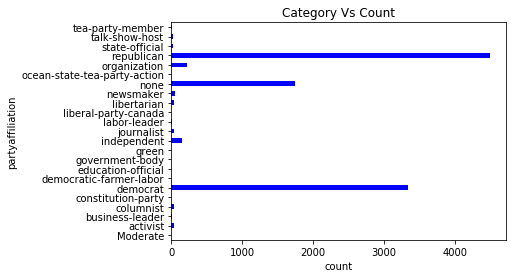

Test Data Party Affiliation Label Distribution Visualization


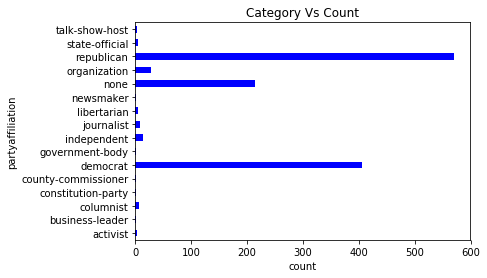

In [94]:
print('Train Data Party Affiliation Label Distribution Visualization')
political_affiliation_distribution(df_train)

print('Test Data Party Affiliation Label Distribution Visualization')
political_affiliation_distribution(df_test)

In [95]:
#label encoding
labels = ['democrat','republican','independent']

def encode_party_affiliation_type(input_label):
    if input_label not in labels:
        return str('other')
    else:
        return input_label

Train Data Party Affiliation Encoded Label Distribution Visualization


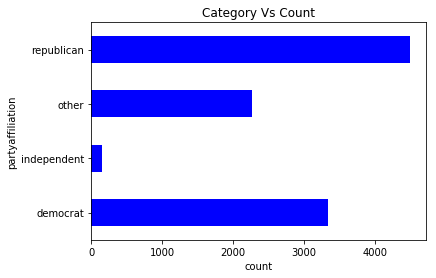

Test Data Party Affiliation Encoded Label Distribution Visualization


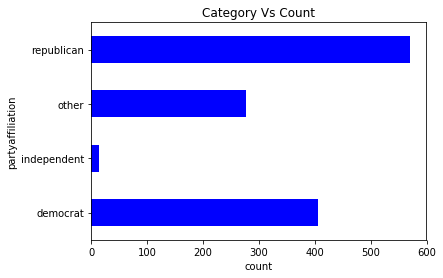

In [96]:
df_train['partyaffiliation'] = df_train.apply(lambda row: encode_party_affiliation_type(row['partyaffiliation']), axis=1)
df_test['partyaffiliation'] = df_test.apply(lambda row: encode_party_affiliation_type(row['partyaffiliation']), axis=1)

print('Train Data Party Affiliation Encoded Label Distribution Visualization')
political_affiliation_distribution(df_train)

print('Test Data Party Affiliation Encoded Label Distribution Visualization')
political_affiliation_distribution(df_test)

**Label Encoding:** Converting the party affiliation labels to encoded format. Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. Party affilition labels are encoded as follows: 1: Republican, 2: Democrat, 3:Other, 4:Independent. I have considered the distribution of labels for encoding. As more records are Republican I have assigned the least values label to avoid bias due to more data being present.

In [97]:
#encode party affiliation labels
def convert_partyaffiliation_category(df):
    partyaffiliation_dict = {'independent':4, 'other':3, 'democrat':2, 'republican':1}
    pa = []
    for index,row in df.iterrows():
        pa.append(partyaffiliation_dict[row['partyaffiliation']])
    return pa

pa_encode_train = pd.DataFrame(convert_partyaffiliation_category(df_train))
df_train['partyaffiliation_encode'] = pa_encode_train

pa_encode_test = pd.DataFrame(convert_partyaffiliation_category(df_test))
df_test['partyaffiliation_encode'] = pa_encode_test

df_train.head(5)

,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,partyaffiliation_encode
0,anni list polit group support thirdtrimest abo...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,0,1
1,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,1,2
2,hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,Denver,1,2
3,health care reform legisl like mandat free cha...,health-care,blog-posting,NaN,NaN,other,a news release,0,3
4,econom turnaround start term,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN,1,2


#### TF-IDF

A brief about this approach

**Create Dictionary:** Categorize data based on party affiliation tag. For each tag, find the top 10 frequently occuring words. Use this as a dictionary for the respective tag. 

**TF-IDF:** Tf-idf stands for term frequency-inverse document frequency. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Using the dictionary created in the previous step, I have calculated the TF-IDF vector for each article on the basis of frequency of the words. I have not used scikit learn vectorizer, instead performed a manual TF-IDF calculation.

**Steps Followed:**

1. Based on party affiliaition feature present in the Liar Liar data set, I have identified the top most occuring words for each of the category.
2. Use this as the dictionary and perform a manual TF-IDF evaluation. 
3. Classify TF-IDF vectors into different political affiliation.

In [98]:
#Method to find the frequency of words per party affiliation tag
def find_freq_dist_per_party(df, label):
    frequencty_dist = []
    data = df[df['partyaffiliation'] == str(label)]
    text_str = ' '.join(data['headline_text'])
    allWords = nltk.tokenize.word_tokenize(text_str)
    allWordsDist = nltk.FreqDist(w.lower() for w in allWords)
    for word, frequency in allWordsDist.most_common(10):
        dist = {"word":word, 'frequency':frequency, 'label':label}
        frequencty_dist.append(dist)
    return frequencty_dist

In [99]:
frequency_dist = find_freq_dist_per_party(df_train, 'democrat')
frequency_dist.extend(find_freq_dist_per_party(df_train, 'republican'))
frequency_dist.extend(find_freq_dist_per_party(df_train, 'independent'))
frequency_dist.extend(find_freq_dist_per_party(df_train, 'other'))

party_affiliation_dict = pd.DataFrame(frequency_dist)

In [100]:
#Find frequency of dictionary in each doc
#Divide by total number of words in dictionary
def computeTF(df, dictionary):
    TF = []
    dict_words = dictionary['word'].unique()
    for index, row in df.iterrows():
        row_freq = []
        words = row['headline_text'].split()
        for i in range(len(dict_words)):
            frequency = float(words.count(dict_words[i])/len(dict_words))
            row_freq.append(frequency)
        TF.append(row_freq)
    return TF

In [101]:
#Calculate IDF for the dictionary
import math
def computeIDF(df, dictionary):
    IDF = []
    dict_words = dictionary['word'].unique()
    num_of_docs = len(df)
    for i in range(len(dict_words)):
        count = 0
        for index,row in df.iterrows():
            if dict_words[i] in row['headline_text']:
                count += 1
        IDF.append(math.log(num_of_docs/count))
    return IDF

In [102]:
#Calculate TF-IDF for each headline text based on the dictionary created
def computeTFIDF(TF, IDF):
    TFIDF = []
    IDF = np.asarray(IDF)
    for j in TF:
        tfidf = np.asarray(j) * IDF.T
        TFIDF.append(tfidf)
    return TFIDF

In [103]:
#Method to calculate model accuracy, precision
def estimate_score(y_test, y_pred):
    score(y_test, y_pred, average='macro')
    precision, recall, fscore, support = score(y_test, y_pred)
    
    print('accuracy: {}'.format(accuracy_score(y_test,y_pred)*100))
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
    
    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [104]:
#TF-IDF for train data
TF_scores = computeTF(df_train, party_affiliation_dict)
IDF_scores = computeIDF(df_train, party_affiliation_dict)
TFIDF_scores = computeTFIDF(TF_scores, IDF_scores)

In [105]:
#TF-IDF for test data
TF_test_scores = computeTF(df_test, party_affiliation_dict)
IDF_test_scores = computeIDF(df_test, party_affiliation_dict)
TFIDF_stest_cores = computeTFIDF(TF_test_scores, IDF_test_scores)

accuracy: 43.96211523283347
precision: [0.45089667 0.30208333 0.         0.        ]
recall: [0.92469352 0.07142857 0.         0.        ]
fscore: [0.60619977 0.11553785 0.         0.        ]
support: [571 406 276  14]


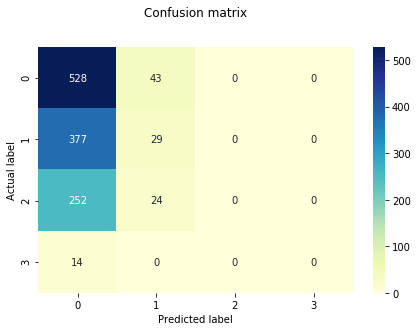

In [106]:
#Political affiliation classification based on TF-IDF
from sklearn.linear_model import LogisticRegression
X, y = TFIDF_scores, df_train['partyaffiliation_encode']
logistic_regression = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf = logistic_regression.fit(X, y)
y_pred = logistic_regression.predict(TFIDF_stest_cores)
estimate_score(df_test['partyaffiliation_encode'], y_pred)

#### Doc2Vec Approach to classify text for political affiliation

**Doc2Vec**: Doc2vec is an unsupervised algorithm to generate vectors for sentence/paragraphs/documents. Doc2Vec is an adaptation of word2vec model. The vectors generated by doc2vec can be used for tasks like finding similarity between sentences/paragraphs/document

**Doc2Vec Parameters**:
1. Using Distributed bag of words dm=0
2. Feature Dimension - 500
3. Set min_count=2 ignoring words in text whose frequence is lower than 2
4. Vector Size is 19(accuracy improved tried 15 and 25. 19 gave the best results)

**Steps Followed**:
1. Tag each document based on party affiliation vector.
2. Run Doc2Vec model
3. Run Logistic Regression to perform multi-class classification

**Classification Report**
Logistic Regression classification yields only 45% accuracy.

In [107]:
#tag each headline text with the label found in previous step
def tag_headline(df, label):
    tagged_text = []
    for index, row in df.iterrows():
        tagged_text.append(TaggedDocument(words=word_tokenize(row['headline_text']), tags=[row[label]]))
    return tagged_text

In [108]:
#Method to convert doc2vec model and tagged documents into vectors training and testing
def create_vector_for_learning(model, tagged_docs):
    #documents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in tagged_docs])
    return targets, regressors

In [109]:
#tag documents based on party affiliation
tagged_pa_text_train = tag_headline(df_train, 'partyaffiliation_encode')
tagged_pa_text_test = tag_headline(df_test, 'partyaffiliation_encode')

#train doc2vec model
doc2vec_model_pa_train = Doc2Vec(documents = tagged_pa_text_train, dm=0, num_features=500, min_count=2, size=20, window=4)
doc2vec_model_pa_test = Doc2Vec(documents = tagged_pa_text_test, dm=0, num_features=500, min_count=2, size=20, window=4)

#prepare test and train data set
y_pa_train, X_pa_train = create_vector_for_learning(doc2vec_model_pa_train, tagged_pa_text_train)
y_pa_test, X_pa_test = create_vector_for_learning(doc2vec_model_pa_test, tagged_pa_text_test)

accuracy: 45.06708760852407
precision: [0.45102686 0.         0.         0.        ]
recall: [1. 0. 0. 0.]
fscore: [0.62166576 0.         0.         0.        ]
support: [571 406 276  14]


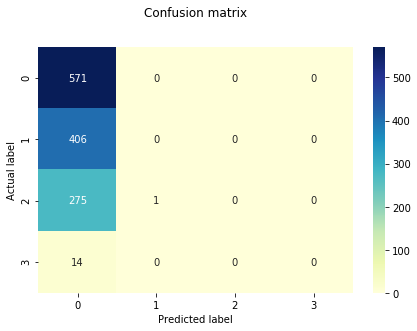

In [110]:
#perform vector classification using Logistic Regression
pa_classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
pa_classifier.fit(X_pa_train, y_pa_train)
y_pa_pred = pa_classifier.predict(X_pa_test)
estimate_score(y_pa_test, y_pa_pred)

#### Applying Distillation

**Distillation:** Distilling the most representative information from a text but also excluding the general background information to produce a more informative low-dimensional vector representation for the text. A very simple way to improve the performance of almost any machine learning algorithm is to train many different models on the same data and then to average their predictions. Combining multiple models into an ensemble by averaging their predictions is a proven strategy to improve model performance. While predicting with an ensemble is expensive at test time, we use distillation mechanism which allow us to compress expensive ensemble into smaller models and combine them to improve accuracy. The results from distillation is combined to form a single feature and later features from each member of the group is represented in a polynomial equation to build a fake news classifier.

**Steps followed in Distillation**
1. Sentiment Analysis
2. Topic modelling using LDA
3. Ranking based on Speaker importance

**Sentiment Analysis**: Sentiment Analysis, or Opinion Mining, is a sub-field of Natural Language Processing (NLP) that tries to identify and extract opinions within a given text. The aim of sentiment analysis is to gauge the attitude, sentiments, evaluations, attitudes and emotions of a speaker/writer based on the computational treatment of subjectivity in a text. According to many research, sentiment analysis is important for fake news identification. A research suggest that if a news is positive the probablity of it being fake is more. Text Sentiment is derived using Vader Sentiment Library. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive, negative or neutral.

**Analysis:** The sentiment polarity score is used to tag the document as Positive , Negative or Neutral based on the max polarity score from the Vader analyser. The values are then normalized using log to achieve better accuracy. I have not used the encoded label as is but normalized the value so that the classifier does not weigh a particular sentiment more than the other. Hence, normalization using math.log() is performed.

In [111]:
#Vader Sentiment Analyser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [112]:
#Calculate sentiment polarity and find the max value. Normalize the encoded label values.
def sentiment_analyzer_scores(df):
    sentiment_score = []
    sentiment_labels = {0:'negative', 1:'positive', 2:'neutral'}
    for index,row in df.iterrows():
        score = analyser.polarity_scores(row['headline_text'])
        values = [score['neg'], score['pos'], score['neu']]
        max_index = values.index(max(values))
        data = {'senti_score':score, 'senti_label':sentiment_labels[max_index], 'senti_label_encode': 1+math.log(max_index+1)}
        sentiment_score.append(data)
    return sentiment_score

In [113]:
#find sentiment scores for test and train headline text
sentiment_score_train = sentiment_analyzer_scores(df_train)
sentiment_score_test = sentiment_analyzer_scores(df_test)

In [114]:
#append dataset with sentiment label and normalized encoded value
sentiment_score_train = pd.DataFrame(sentiment_score_train)
df_train['sentiment'] = sentiment_score_train['senti_label']
df_train['sentiment_encode'] = sentiment_score_train['senti_label_encode']

sentiment_score_test = pd.DataFrame(sentiment_score_test)
df_test['sentiment'] = sentiment_score_test['senti_label']
df_test['sentiment_encode'] = sentiment_score_test['senti_label_encode']

In [115]:
"""#tag documents based on party affiliation
tagged_senti_text_train = tag_headline(df_train, 'sentiment_encode')
tagged_senti_text_test = tag_headline(df_test, 'sentiment_encode')

#train doc2vec model
doc2vec_model_senti_train = Doc2Vec(documents = tagged_senti_text_train, dm=0, num_features=500, min_count=2, size=19, window=4)
doc2vec_model_senti_test = Doc2Vec(documents = tagged_senti_text_test, dm=0, num_features=500, min_count=2, size=19, window=4)

#prepare test and train data set
y_senti_train, X_senti_train = create_vector_for_learning(doc2vec_model_senti_train, tagged_senti_text_train)
y_senti_test, X_senti_test = create_vector_for_learning(doc2vec_model_senti_test, tagged_senti_text_test)"""

"#tag documents based on party affiliation\ntagged_senti_text_train = tag_headline(df_train, 'sentiment_encode')\ntagged_senti_text_test = tag_headline(df_test, 'sentiment_encode')\n\n#train doc2vec model\ndoc2vec_model_senti_train = Doc2Vec(documents = tagged_senti_text_train, dm=0, num_features=500, min_count=2, size=19, window=4)\ndoc2vec_model_senti_test = Doc2Vec(documents = tagged_senti_text_test, dm=0, num_features=500, min_count=2, size=19, window=4)\n\n#prepare test and train data set\ny_senti_train, X_senti_train = create_vector_for_learning(doc2vec_model_senti_train, tagged_senti_text_train)\ny_senti_test, X_senti_test = create_vector_for_learning(doc2vec_model_senti_test, tagged_senti_text_test)"

In [116]:
"""#perform vector classification using Logistic Regression
senti_classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
senti_classifier.fit(X_senti_train, y_senti_train)
y_senti_pred = senti_classifier.predict(X_senti_test)
estimate_score(y_senti_test, y_senti_pred)"""

"#perform vector classification using Logistic Regression\nsenti_classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')\nsenti_classifier.fit(X_senti_train, y_senti_train)\ny_senti_pred = senti_classifier.predict(X_senti_test)\nestimate_score(y_senti_test, y_senti_pred)"

#### Topic Modelling

**Latent Dirichlet Allocation:** Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word. In LDA, the modelling process revolves around three things: the text corpus, its collection of documents, D and the words W in the documents. Therefore the algorithm attempts to uncover K topics from this corpus.

The LDA algorithm first models documents via a mixture model of topics. From these topics, words are then assigned weights based on the probability distribution of these topics. It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.

From a standard LDA model, there are really a few key parameters that we have to keep in mind and consider programmatically tuning before we invoke the model:

1. n_components: The number of topics that you specify to the model
2. α  parameter: This is the dirichlet parameter that can be linked to the document topic prior
3. β  parameter: This is the dirichlet parameter linked to the topic word prior

**Analysis:** I have chosen topic score, which is a probablitiy of how much percentage the headline is close to the topic instead of the topic number. The topic numbers are in the range of 1 to 10. If I use the topic range then the classifier adds more weightage to topic 10 even though this is not the right form of ranking. Topic score is a value between 0 and 1 which is more appropriate.

In [117]:
#tokenization - process of splitting text to words
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result

In [118]:
#train LDA model. Build a dictionary using train data set. Build a corpus using the Bag of words model. Using this corpus we build LDA model to provide the top 10 topics.
documents = df_train[['headline_text']]
processed_docs = documents['headline_text'].map(get_word_tokens)
dictionary = gensim.corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [119]:
#Idnetify the topic number and the topic score for each headline text in test and train data set
def identify_topic_number_score(text):
    bow_vector = dictionary.doc2bow(get_word_tokens(text))
    topic_number , topic_score = sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[0]
    #print (topic_number, topic_score)
    return pd.Series([topic_number, topic_score])

In [120]:
#topic modelling for train data
df_train[['topic_number','topic_score']] = df_train.apply(lambda row: identify_topic_number_score(row['headline_text']), axis=1)
df_train.head(5)

,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,partyaffiliation_encode,sentiment,sentiment_encode,topic_number,topic_score
0,anni list polit group support thirdtrimest abo...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,0,1,neutral,2.098612,9.0,0.899981
1,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,1,2,neutral,2.098612,3.0,0.930751
2,hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,Denver,1,2,neutral,2.098612,4.0,0.647750
3,health care reform legisl like mandat free cha...,health-care,blog-posting,NaN,NaN,other,a news release,0,3,positive,1.693147,0.0,0.909982
4,econom turnaround start term,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN,1,2,neutral,2.098612,2.0,0.819973


In [121]:
#topic modelling for test data
df_test[['topic_number','topic_score']] = df_test.apply(lambda row: identify_topic_number_score(row['headline_text']), axis=1)
df_test.head(5)

,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,partyaffiliation_encode,sentiment,sentiment_encode,topic_number,topic_score
0,build wall usmexico border take liter years,immigration,rick-perry,Governor,Texas,republican,Radio interview,1,1,neutral,2.098612,4.0,0.638051
1,wisconsin pace doubl number layoff year,jobs,katrina-shankland,State representative,Wisconsin,democrat,a news conference,0,2,neutral,2.098612,6.0,0.871400
2,john mccain done noth help vets,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,comments on ABC's This Week.,0,1,neutral,2.098612,2.0,0.700423
3,suzann bonamici support plan choic medicar adv...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,a radio show,1,1,neutral,2.098612,4.0,0.899963
4,report whether center crimin scheme violat cam...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,a web video,0,2,neutral,2.098612,0.0,0.605625


In [122]:
#Topic distirbution visualization of test and train data
def create_topic_distribution(df):
    g = sns.countplot(x='topic_number', data=df, palette='hls')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)

    return g

Train Data Topic Distribution Visualization


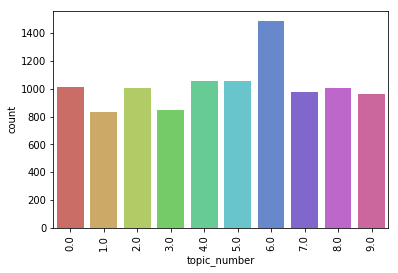

In [123]:
print('Train Data Topic Distribution Visualization')
create_topic_distribution(df_train)

Test Data Topic Distribution Visualization


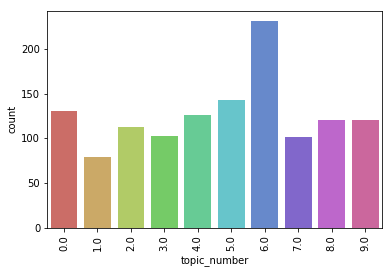

In [124]:
print('Test Data Topic Distribution Visualization')
create_topic_distribution(df_test)

**Ranking Party Affiliation**

Based on the frequency of the tags present in the train dataset a normalized weight is calculated for each label. This weight is applied on the coefficients of the regression and used as a vector. This process is done for both the part affiliation vector and sentiment vector. **Commenting this section as the method did not work in final classification. Accuracy declined**

In [125]:
"""def rank_political_affiliation_vector():
    pa_classifier_coef = pa_classifier.coef_
    pa_classifier_classes = pa_classifier.classes_
    
    pa_train = []
    for i in range(len(df_train['partyaffiliation_encode'])):
        pa_value = df_train['partyaffiliation_encode'][i]
        pa = doc2vec_model_pa_train[pa_value]*pa_classifier_coef[pa_value-1]
        pa_train.append(pa)
    return pa_train"""

"def rank_political_affiliation_vector():\n    pa_classifier_coef = pa_classifier.coef_\n    pa_classifier_classes = pa_classifier.classes_\n    \n    pa_train = []\n    for i in range(len(df_train['partyaffiliation_encode'])):\n        pa_value = df_train['partyaffiliation_encode'][i]\n        pa = doc2vec_model_pa_train[pa_value]*pa_classifier_coef[pa_value-1]\n        pa_train.append(pa)\n    return pa_train"

In [126]:
"""def rank_political_affiliation_test_vector():
    pa_classifier_coef = pa_classifier.coef_
    pa_classifier_classes = pa_classifier.classes_
    
    pa_test = []
    for i in range(len(y_pa_pred)):
        pa_value = y_pa_pred[i]
        pa = doc2vec_model_pa_test[pa_value]*pa_classifier_coef[pa_value-1]
        pa_test.append(pa)
    return pa_test"""

'def rank_political_affiliation_test_vector():\n    pa_classifier_coef = pa_classifier.coef_\n    pa_classifier_classes = pa_classifier.classes_\n    \n    pa_test = []\n    for i in range(len(y_pa_pred)):\n        pa_value = y_pa_pred[i]\n        pa = doc2vec_model_pa_test[pa_value]*pa_classifier_coef[pa_value-1]\n        pa_test.append(pa)\n    return pa_test'

In [127]:
"""def rank_sentiment_vector():
    senti_classifier_coef = senti_classifier.coef_
    senti_classifier_classes = senti_classifier.classes_
    
    senti_train = []
    for i in range(len(df_train['partyaffiliation_encode'])):
        senti_value = df_train['sentiment_encode'][i]
        senti = doc2vec_model_pa_train[senti_value]*senti_classifier_coef[senti_value-1]
        senti_train.append(senti)
    return senti_train"""

"def rank_sentiment_vector():\n    senti_classifier_coef = senti_classifier.coef_\n    senti_classifier_classes = senti_classifier.classes_\n    \n    senti_train = []\n    for i in range(len(df_train['partyaffiliation_encode'])):\n        senti_value = df_train['sentiment_encode'][i]\n        senti = doc2vec_model_pa_train[senti_value]*senti_classifier_coef[senti_value-1]\n        senti_train.append(senti)\n    return senti_train"

In [128]:
"""def rank_sentiment_test_vector():
    senti_classifier_coef = senti_classifier.coef_
    senti_classifier_classes = senti_classifier.classes_
    
    senti_test = []
    for i in range(len(y_pa_pred)):
        senti_value = y_senti_pred[i]
        senti = doc2vec_model_senti_test[senti_value]*senti_classifier_coef[senti_value-1]
        senti_test.append(senti)
    return senti_test"""

'def rank_sentiment_test_vector():\n    senti_classifier_coef = senti_classifier.coef_\n    senti_classifier_classes = senti_classifier.classes_\n    \n    senti_test = []\n    for i in range(len(y_pa_pred)):\n        senti_value = y_senti_pred[i]\n        senti = doc2vec_model_senti_test[senti_value]*senti_classifier_coef[senti_value-1]\n        senti_test.append(senti)\n    return senti_test'

#### Ranking

**Speaker Importance:** Te top 10 speakers from the train data set is fetched. Each of these speaker is given a rank value based on the frequency in the corpus.

In [129]:
def speaker_distribution(df):
    #Training data set with text, domain ranking and type.
    X = df[['headline_text', 'speaker']]

    plt.title('Category Vs Count')
    X.groupby(['speaker']).size().sort_values(ascending=False).head(10).plot(kind='barh', color='blue')
    plt.xlabel('count')
    plt.show()

Train Data Visualization


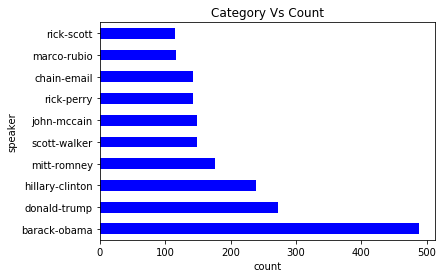

Test Data Visualization


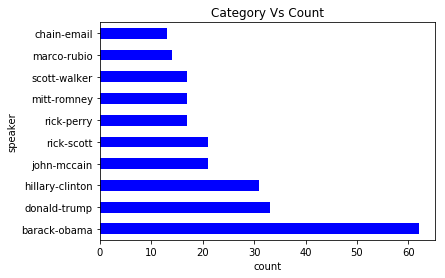

In [130]:
print('Train Data Visualization')
speaker_distribution(df_train)

print('Test Data Visualization')
speaker_distribution(df_test)

In [131]:
import collections
def find_top_10_speakers(df):
    #Training data set with text, domain ranking and type.
    #X = df[['headline_text', 'speaker']]
    #groups = X.groupby(['speaker']).size().sort_values(ascending=False).head(10)
    #print(groups[0])
    top_10 = []
    frequency = collections.Counter(df['speaker'])
    values = frequency.most_common()
    for i in range(10):
        speaker_freq = {'speaker':values[i][0], 'frequency':values[i][1]}
        #print(speaker_freq)
        top_10.append(speaker_freq)
    return top_10
        
    
speaker_freq = pd.DataFrame(find_top_10_speakers(df_train))
print("The top 10 speakers")
speaker_freq

The top 10 speakers


,frequency,speaker
0,488,barack-obama
1,273,donald-trump
2,239,hillary-clinton
3,176,mitt-romney
4,149,scott-walker
5,148,john-mccain
6,142,chain-email
7,142,rick-perry
8,117,marco-rubio
9,115,rick-scott


In [132]:
#assign speaker importance by taking log of frequency. For speakers not in this top 10 list I will assign least value of 1
def assign_speaker_rank(df):
    speakers = speaker_freq['speaker']
    frequency = speaker_freq['frequency']
    ranks = {}
    index = 0
    for i in speakers:
        ranks[i] = math.log(frequency[index])
        index += 1
    
    speaker_rank = []
    for index,row in df.iterrows():
        if row['speaker'] not in ranks:
            speaker_rank.append(1)
        else:
            speaker_rank.append(ranks[row['speaker']])
            
    return speaker_rank

In [133]:
#find speaker importance for train data
speaker_rank = assign_speaker_rank(df_train)
df_train['speaker_rank'] = speaker_rank
df_train.head(5)

,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,partyaffiliation_encode,sentiment,sentiment_encode,topic_number,topic_score,speaker_rank
0,anni list polit group support thirdtrimest abo...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,0,1,neutral,2.098612,9.0,0.899981,1.000000
1,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,1,2,neutral,2.098612,3.0,0.930751,1.000000
2,hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,Denver,1,2,neutral,2.098612,4.0,0.647750,6.190315
3,health care reform legisl like mandat free cha...,health-care,blog-posting,NaN,NaN,other,a news release,0,3,positive,1.693147,0.0,0.909982,1.000000
4,econom turnaround start term,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN,1,2,neutral,2.098612,2.0,0.819973,1.000000


In [134]:
#find speaker importance for test data
speaker_rank_test = assign_speaker_rank(df_test)
df_test['speaker_rank'] = speaker_rank_test
df_test.head(5)

,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,partyaffiliation_encode,sentiment,sentiment_encode,topic_number,topic_score,speaker_rank
0,build wall usmexico border take liter years,immigration,rick-perry,Governor,Texas,republican,Radio interview,1,1,neutral,2.098612,4.0,0.638051,4.955827
1,wisconsin pace doubl number layoff year,jobs,katrina-shankland,State representative,Wisconsin,democrat,a news conference,0,2,neutral,2.098612,6.0,0.871400,1.000000
2,john mccain done noth help vets,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,comments on ABC's This Week.,0,1,neutral,2.098612,2.0,0.700423,5.609472
3,suzann bonamici support plan choic medicar adv...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,a radio show,1,1,neutral,2.098612,4.0,0.899963,1.000000
4,report whether center crimin scheme violat cam...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,a web video,0,2,neutral,2.098612,0.0,0.605625,1.000000


#### Let's Classify

**Techniques to form feature vector:**

1. **Scalar Vector Addition:** The sclar values sentiment score, topic score, rank is added to the doc2vec political affiliation feature.
2. **Vector Embedding:** In this technique, the doc2vec model is embedded with sentiment score, topic score and rank value.

I was able to achieve an accuracy of **56%** which is evidently more(without distillation **37%**) than what I have been able to achieve without distillation process.

**Technique 1 Scalar Vector Addition**

In [135]:
#Scalar Vector Addition Train vector
def get_political_affiliation_train_vector():
    pa_train = []
    for i in range(len(df_train['partyaffiliation_encode'])):
        pa_value = df_train['partyaffiliation_encode'][i]
        pa = doc2vec_model_pa_train[pa_value] + df_train['sentiment_encode'][i] + df_train['topic_score'][i] + df_train['speaker_rank'][i]
        pa_train.append(pa)
    return pa_train

In [136]:
#Scalar Vector Addition Test vector
def get_political_affiliation_test_vector():
    pa_test = []
    for i in range(len(df_test['partyaffiliation_encode'])):
        pa_value = df_test['partyaffiliation_encode'][i]
        pa = doc2vec_model_pa_test[pa_value] + df_test['sentiment_encode'][i] + df_test['topic_score'][i] + df_test['speaker_rank'][i]
        pa_test.append(pa)
    return pa_test

In [137]:
#Get train and test data for classification
X_train = get_political_affiliation_train_vector()
y_train = df_train['encoded_label']

X_test = get_political_affiliation_test_vector()
y_test = df_test['encoded_label']

accuracy: 56.353591160220994
precision: [0.         0.56353591]
recall: [0. 1.]
fscore: [0.         0.72084806]
support: [553 714]


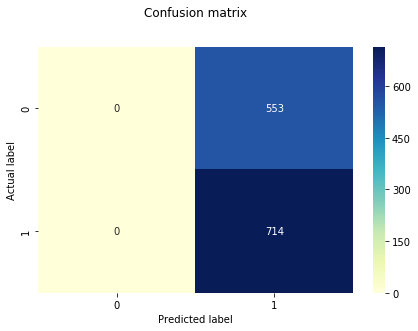

In [138]:
#perform vector classification using Logistic Regression
fake_news_classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
fake_news_classifier.fit(X_train, y_train)
y_pred = fake_news_classifier.predict(X_test)
estimate_score(y_test, y_pred)

**Technique 2 Vector Embedding**

In [139]:
#Vector Embedding Train vector
def getPoliticalAffiliationTrainFeatureVector():   
    sentiment = df_train.sentiment_encode.reset_index()['sentiment_encode']
    topic = df_train.topic_score.reset_index()['topic_score']
    rank = df_train.speaker_rank.reset_index()['speaker_rank']
    pa_doc2vec = []
    for i in range(len(df_train['partyaffiliation_encode'])):
        pa_value = df_train['partyaffiliation_encode'][i]
        pa = doc2vec_model_pa_train[pa_value]
        pa_doc2vec.append(pa)
    
    political_affiliation_vector = pd.concat([sentiment,topic, rank, pd.DataFrame(pa_doc2vec)],axis=1)
    return political_affiliation_vector

In [140]:
#Vector Embedding Test vector
def getPoliticalAffiliationTestFeatureVector():
    sentiment = df_test.sentiment_encode.reset_index()['sentiment_encode']
    topic = df_test.topic_score.reset_index()['topic_score']
    rank = df_test.speaker_rank.reset_index()['speaker_rank']
    pa_doc2vec = []
    for i in range(len(df_test['partyaffiliation_encode'])):
        pa_value = df_test['partyaffiliation_encode'][i]
        pa = doc2vec_model_pa_test[pa_value]
        pa_doc2vec.append(pa)
    
    political_affiliation_test_vector = pd.concat([sentiment,topic, rank, pd.DataFrame(pa_doc2vec)],axis=1)
    return political_affiliation_test_vector

In [141]:
#Get train and test data for classification
X_train = getPoliticalAffiliationTrainFeatureVector()
y_train = df_train['encoded_label']

X_test = getPoliticalAffiliationTestFeatureVector()
y_test = df_test['encoded_label']

accuracy: 56.353591160220994
precision: [0.         0.56353591]
recall: [0. 1.]
fscore: [0.         0.72084806]
support: [553 714]


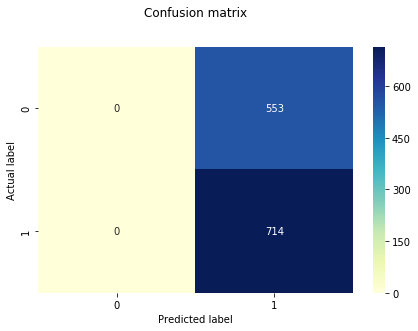

In [142]:
#perform vector classification using Logistic Regression
fake_news_classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
fake_news_classifier.fit(X_train, y_train)
y_pred = fake_news_classifier.predict(X_test)
estimate_score(y_test, y_pred)

accuracy: 56.353591160220994
precision: [0.         0.56353591]
recall: [0. 1.]
fscore: [0.         0.72084806]
support: [553 714]


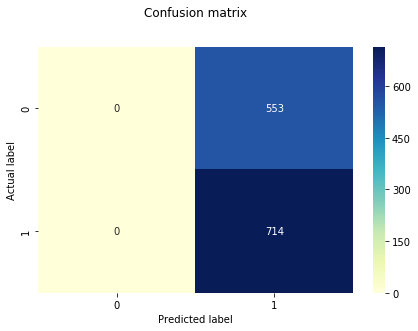

In [143]:
#perform vector classification using SVM
from sklearn.svm import SVC
fake_news_svm_classifier = SVC(kernel = 'linear', random_state = 42)
model = fake_news_svm_classifier.fit(X_train,y_train)
y_pred = model.predict(X_test)
estimate_score(y_test, y_pred)

accuracy: 51.223362273086025
precision: [0.40298507 0.55150215]
recall: [0.24412297 0.71988796]
fscore: [0.30405405 0.62454435]
support: [553 714]


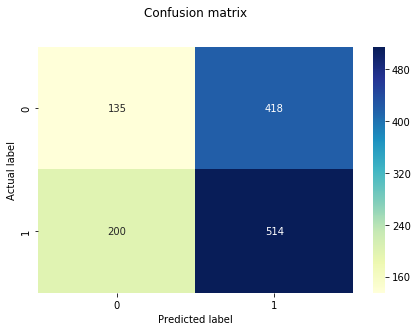

In [144]:
#perform vector classification using Random Classifier
fake_news_rf_classifier = RandomForestClassifier(n_jobs=-1,n_estimators=200,max_depth=90)
model = fake_news_rf_classifier.fit(X_train,y_train)
y_pred = model.predict(X_test)
estimate_score(y_test, y_pred)

#### Classification Reports and Inferences
    
- **Doc2Vec Model**
    - Logisitic Regression: 56.35%
    - SVM: 56.35%
    - Random Forest: 50.98%

**Classification Algorithm Performance Inferences:** Logistic Regression has performed better than Random Forest. SVM is also giving good accuracy as the problem is converted to a binary classification problem.

**TF-IDF Vs Count Vector Vs Word Embedding Inferences:** TF-IDF and Count Verctor results were not satisfactory. Doc2Vec outperformed TF-IDF. Doc2 vec was rich or big enough for the model to learn actual contextual relations to generate sensible embeddings .

#### Next Steps

**Ensemble Model:**
After feature engineering is performed, the political affiliation feature vector is used along with other features to classify fake news using polynomial equation and the ensemble technique. Ensemble methods are techniques that create multiple models and then combine them to produce improved results. Ensemble methods usually produces more accurate solutions than a single model would. The algorithms such as logistic regression, decision tree or any other machine learning algorithms constitutes ensemble algorithm. These are suitable for building multi-label classifiers. One popular ensemble technique that I have followed is **stacked generalization**. Stacked generalization, is an ensemble method where the models are combined using another machine learning algorithm. The basic idea is to train machine learning algorithms with training dataset and then generate a new dataset with these models. Then this new dataset is used as input for the combiner machine learning algorithm.

In [145]:
#Writing vector features to file
def write_to_csv(df, vector_data, filename):
    feature = []
    for index,row in vector_data.iterrows():
        feature.append(row.tolist())
    
    final_feature = []
    for i in range(len(df)):
        data = {}
        headline = df['headline_text'][i]
        encoded_label = df['encoded_label'][i]
        political_affiliation_vector = feature[i]
    
        data = {'headline_text':headline, 'encoded_label':encoded_label, 'political_affiliation_vector':political_affiliation_vector}
        final_feature.append(data)

    df = pd.DataFrame(final_feature)
    df.to_csv(filename, sep=',')

In [146]:
write_to_csv(df_train, X_train, 'political_affiliation_feature_train.csv')
write_to_csv(df_test, X_test, 'political_affiliation_feature_test.csv')